# LLM-Lasso Tutorial

## 1. Setup Instructions
1. Install `LLM-Lasso` as an editable package:
    ```
    $ pip install -e .
    ```
    for `pip`, or
    ```
    $ conda develop .
    ```
    for `conda`. Note that this requires you to `conda install conda-build`.

2. Initialize the `adelie` submodule:
    ```
    $ git submodule init
    $ git submodule update
    ```
3. Install `adelie` as an editable package (`adelie` is used for solving LASSO with penalty factors).
    ```
    $ cd adelie-fork
    $ pip install -e .
    ```
    or the equivalent for `conda`.

   


5. Copy the file `sample_constants.py` to `_my_constants.py` and populate relevant API keys.

The values from `_my_constants.py` are automatically loaded into `constants.py`.

### 1.1 Common issues:
Intalling `adelie` as an editable package requires compiling from source, which may come with several issues:
- `adelie` requires some C++ libraries, namely `eigen`, `llvm`, and `openmp` (which may be installed as `libomp`). For Unix-based systems, these should be available through your package manager, and releases are also available online.
- There may issues with the `eigen` library (and others) not being in the `C_INCLUDE_PATH` and `CPLUS_INCLUDE_PATH`. For this, you need to:
    - Find where the `eigen` include directory is on your machine (it should be a directory with subdirectories `Eigen` and `unsupported`). For macOS with `eigen` installed via `homebrew`, this may be in a directory that looks like `/opt/homebrew/Cellar/eigen/3.4.0_1/include/eigen3/`. For linux, this may be `/usr/include/eigen3/` or `/usr/local/include/eigen3/`, for instance.

    - Run the following:
        ```
        $ export C_INCLUDE_PATH="the_path_from_the_previous_step:$C_INCLUDE_PATH"
        $ export CPLUS_INCLUDE_PATH="the_path_from_the_previous_step:$CPLUS_INCLUDE_PATH"
        ```
    You may also have to do this with other libraries, like `libomp`.

- If you installed `llvm` via `homebrew` on macOS, make sure you run the following:
    ```
    $ export LDFLAGS="-L/opt/homebrew/opt/llvm/lib"
    $ export CPPFLAGS="-I/opt/homebrew/opt/llvm/include"
    ```

  

## 2. Includes 

In [38]:
from llm_lasso.task_specific_lasso.llm_lasso import run_repeated_llm_lasso_cv, PenaltyType
from llm_lasso.task_specific_lasso.plotting import plot_heatmap, plot_llm_lasso_result
from llm_lasso.data_splits import read_train_test_splits, read_baseline_splits
import numpy as np
import warnings
import json
warnings.filterwarnings("ignore")  # Suppress warnings

In [2]:
%load_ext autoreload
%autoreload 2

## 3. Small-Scale Classification Example: Diabetes
The first 4 steps will be run on the command line, and the remainder of the tutorial will be run using this notebook.
### Step 1: Generate Training and Test Splits
For evaluation, we consider 50/50 balanced training and test splits generated with different random seeds. As the same splits are used for the LASSO portion of LLM-Lasso and the data-driven baselines, we generate them beforehand.

To generate $k$ train/test splits, run the following in the command line from the base directory of this repository:
```
$ python scripts/small_scale_splits.py \
        --dataset Diabetes \
        --save_dir data/splits/diabetes \
        --n-splits 10
```

### Step 2: Run Data-Driven Baselines
Next, run the baseline feature-selected methods that require access to the training splits, e.g., mutual information.
```
$ python scripts/run_baselines.py \
        --split-dir data/splits/diabetes \
        --n-splits 10 \
        --save-dir data/baselines/diabetes
```

### Step 3: Run the LLM-Score Baseline
For example:
```
$ python scripts/llm_score.py \
        --prompt-filename prompts/llm-select/diabetes_prompt.txt \
        --feature_names_path small_scale/data/Diabetes_feature_names.pkl \
        --category Diabetes \
        --wipe \
        --save_dir data/llm-score/diabetes \
        --n-trials 1 \
        --step 1 \
        --model-type gpt-4o \
        --temp 0
```

### Step 4: Generate LLM-Lasso Penalties
Note that there is no RAG setup for the small-scale datasets, so we will not enable RAG in the following script.
```
$ python scripts/llm_lasso_scores.py \
        --prompt-filename prompts/small_scale_prompts/diabetes_prompt.txt \
        --feature_names_path small_scale/data/Diabetes_feature_names.pkl \
        --category Diabetes \
        --wipe \
        --save_dir data/llm-lasso/diabetes \
        --n-trials 1 \
        --model-type gpt-4o \
        --temp 0
```

### Step 5: Run LLM-Regularized LASSO
First, load in the required data splits, penalty factors, and baseline-selected features.

In [3]:
# Load in splits
N_SPLITS = 10
x_train, x_test, y_train, y_test = read_train_test_splits("../data/splits/diabetes", N_SPLITS)

In [4]:
# Load in LLM-Lasso Penalties
penalty_list={
    "plain": np.array(
        np.load("../data/llm-lasso/diabetes/final_scores_plain.pkl", allow_pickle=True)
    ),
}

In [16]:
# Load in baseline features
feature_baseline = read_baseline_splits("../data/baselines/diabetes", n_splits= N_SPLITS, n_features=len(x_train[0].columns))

with open("../data/llm-score/diabetes/llmselect_selected_features.json", "r") as f:
    llm_select_genes = json.load(f)[f"{len(x_train[0].columns)}"]

feature_baseline["llm_score"] = [llm_select_genes] * N_SPLITS

Next, compute test error and AUROC for LLM-Lasso and the baselines, averaged across the splits.

In [42]:
penalty_list

{'plain': array([3., 2., 4., 4., 3., 2., 3., 3.])}

In [39]:
res = run_repeated_llm_lasso_cv(
    x_train_splits=x_train, x_test_splits=x_test,
    y_train_splits=y_train, y_test_splits=y_test,
    scores=penalty_list,
    feature_baseline=feature_baseline,
    n_splits=N_SPLITS,
    folds_cv=10,
    score_type = PenaltyType.PF,
    lambda_min_ratio=0.001,
    n_threads=8,
)

Processing split 0 of 10
	Running model: plain
Running pf_type Lasso
Running pf_type 1/imp^0
Running pf_type 1/imp^1
Running pf_type 1/imp^2
Running pf_type 1/imp^3
Running pf_type 1/imp^4
Running pf_type 1/imp^5
Running baselines
Processing split 1 of 10
	Running model: plain
Running pf_type Lasso
Running pf_type 1/imp^0
Running pf_type 1/imp^1
Running pf_type 1/imp^2
Running pf_type 1/imp^3
Running pf_type 1/imp^4
Running pf_type 1/imp^5
Running baselines
Processing split 2 of 10
	Running model: plain
Running pf_type Lasso
Running pf_type 1/imp^0
Running pf_type 1/imp^1
Running pf_type 1/imp^2
Running pf_type 1/imp^3
Running pf_type 1/imp^4
Running pf_type 1/imp^5
Running baselines
Processing split 3 of 10
	Running model: plain
Running pf_type Lasso
Running pf_type 1/imp^0
Running pf_type 1/imp^1
Running pf_type 1/imp^2
Running pf_type 1/imp^3
Running pf_type 1/imp^4
Running pf_type 1/imp^5
Running baselines
Processing split 4 of 10
	Running model: plain
Running pf_type Lasso
Running

Plot the test error and AUROC using the dataframe returned by `run_repeated_llm_lasso_cv`.

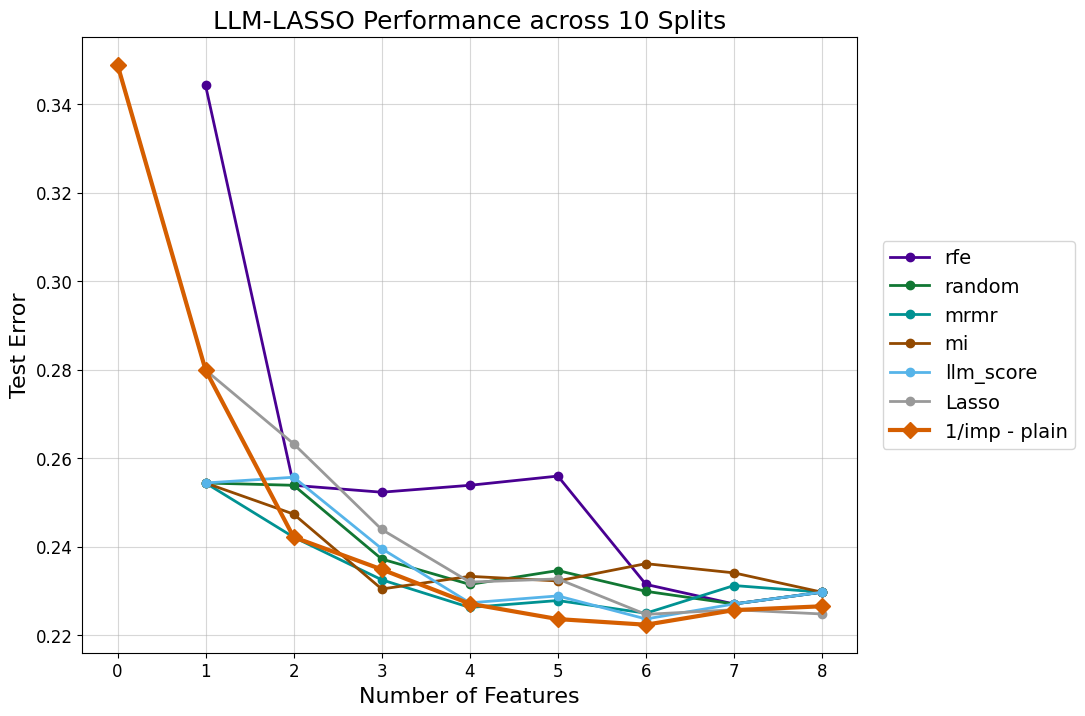

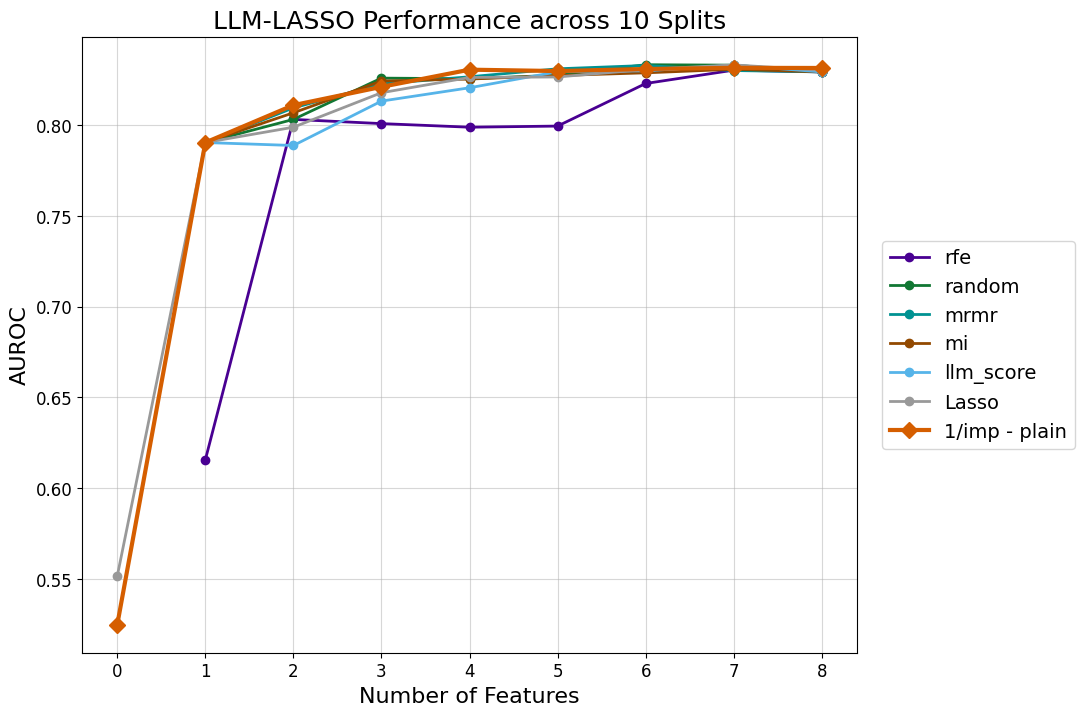

In [40]:
plot_llm_lasso_result(
    res,
    bolded_methods=["1/imp - plain"],
    plot_error_bars=False
)

You can also plot a feature inclusion heatmap.

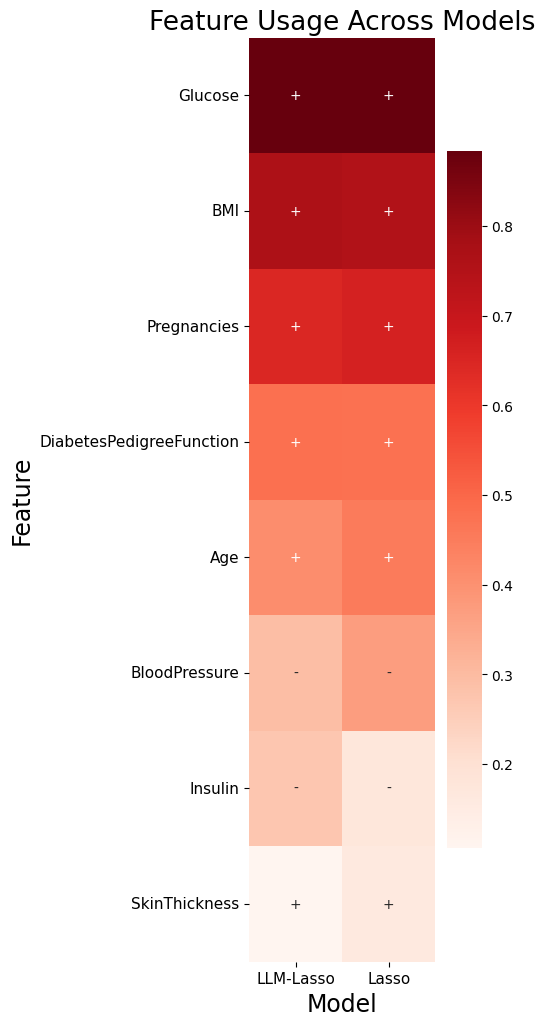

In [41]:
plot_heatmap(
    res,
    method_models=["1/imp - plain", "Lasso"], # these are from the method_model column of the dataframe
    labels=["LLM-Lasso", "Lasso"], # this is how each method_model will be labeled on the plot
    feature_names=x_train[0].columns,
    sort_by="LLM-Lasso"
)

## 4. Small-Scale Regression Example: Spotify
The first 4 steps will be run on the command line, and the remainder of the tutorial will be run using this notebook.
### Command-Line Component
Here are the commands to save data splits, run baselines, and generate penalties, same as for the Diabetes example:
```
$ python scripts/small_scale_splits.py \
        --dataset Spotify \
        --save_dir data/splits/spotify \
        --n-splits 10

$ python scripts/run_baselines.py \
        --split-dir data/splits/spotify \
        --n-splits 10 \
        --save-dir data/baselines/spotify

$ python scripts/llm_score.py \
        --prompt-filename prompts/llm-select/spotify_prompt.txt \
        --feature_names_path small_scale/data/Spotify_feature_names.pkl \
        --category "number of Spotify streams" \
        --wipe \
        --save_dir data/llm-score/spotify \
        --n-trials 1 \
        --step 1 \
        --model-type gpt-4o \
        --temp 0

$ python scripts/llm_lasso_scores.py \
        --prompt-filename prompts/small_scale_prompts/spotify_prompt.txt \
        --feature_names_path small_scale/data/Spotify_feature_names.pkl \
        --category "number of Spotify streams" \
        --wipe \
        --save_dir data/llm-lasso/spotify \
        --n-trials 1 \
        --model-type gpt-4o \
        --temp 0
```

### LLM-Regularized LASSO
First, load in the required data splits, penalty factors, and baseline-selected features.

In [ ]:
# Load in splits
N_SPLITS = 10
x_train, x_test, y_train, y_test = read_train_test_splits("../data/splits/spotify", N_SPLITS)

In [ ]:
# Load in LLM-Lasso Penalties
penalty_list={
    "plain": np.array(
        np.load("../data/llm-lasso/spotify/final_scores_plain.pkl", allow_pickle=True)
    ),
}

In [ ]:
# Load in baseline features
feature_baseline = read_baseline_splits("../data/baselines/spotify", n_splits=N_SPLITS, n_features=len(x_train[0].columns))

with open("../data/llm-score/spotify/llmselect_selected_features.json", "r") as f:
    llm_select_genes = json.load(f)[f"{len(x_train[0].columns)}"]

feature_baseline["llm_score"] = [llm_select_genes] * N_SPLITS

Ccompute test error and AUROC for LLM-Lasso and the baselines, averaged across the splits.

Make sure to pass in **`regression=True`**!

In [ ]:
res = run_repeated_llm_lasso_cv(
    x_train_splits=x_train, x_test_splits=x_test,
    y_train_splits=y_train, y_test_splits=y_test,
    scores=penalty_list,
    feature_baseline=feature_baseline,
    n_splits=N_SPLITS,
    regression=True,
    folds_cv=10,
    score_type = PenaltyType.PF,
    lambda_min_ratio=0.001,
    n_threads=8,
)

Plot the test error and AUROC using the dataframe returned by `run_repeated_llm_lasso_cv`.

In [ ]:
plot_llm_lasso_result(
    res,
    bolded_methods=["1/imp - plain"],
    plot_error_bars=False
)

Plot the feature inclusion heatmap.

In [ ]:
plot_heatmap(
    res,
    method_models=["1/imp - plain", "Lasso"], # these are from the method_model column of the dataframe
    labels=["LLM-Lasso", "Lasso"], # this is how each method_model will be labeled on the plot
    feature_names=x_train[0].columns,
    sort_by="LLM-Lasso"
)